In [1]:
import openmc
import openmc.deplete
import numpy as np
import matplotlib.pyplot as plt
import openmc.zernike as zer

In [2]:
# Depletion simulation parameters
time_step = 1*24*60*60 # s
final_time = 5*24*60*60 # s
time_steps = np.full(final_time // time_step, time_step)
#chain_file = './chain_casl.xml'
chain_file = './chain_simple.xml'
power = 174 # W/cm, for 2D simulations only (use W for 3D)
#
fet_order = 2
fet_norm = 0.39218
#

In [3]:
helium = openmc.Material(material_id=2, name='Helium for gap')
helium.set_density('g/cm3', 0.001598)
helium.add_element('He', 2.4044e-4)
#
zircaloy = openmc.Material(material_id=3, name='Zircaloy 4')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_nuclide('Zr90', 0.98335, 'wo')
#
borated_water = openmc.Material(material_id=4, name='Borated water')
borated_water.set_density('g/cm3', 0.740582)
borated_water.add_element('B', 4.0e-5)
borated_water.add_element('H', 5.0e-2)
borated_water.add_element('O', 2.4e-2)
borated_water.add_s_alpha_beta('c_H_in_H2O')
#
num_poly = zer.num_poly(fet_order)
zz2 = [0.0]*(num_poly-1)
#
uo2= openmc.Material(material_id=6, name='UO2')
uo2.set_density('atom/b-cm', 10.111)
uo2.add_nuclide('U234',  3.18096E-06, zernike=[fet_norm]+[3.18096E-06]+zz2)
uo2.add_nuclide('U235',  3.90500E-04, zernike=[fet_norm]+[3.90500E-04]+zz2)
uo2.add_nuclide('U238',  2.10299E-02, zernike=[fet_norm]+[2.10299E-02]+zz2)
uo2.add_nuclide('O16'  , 4.53705E-02, zernike=[fet_norm]+[4.53705E-02]+zz2)
uo2.depletable = True 
#
mat = openmc.Materials([uo2, helium, zircaloy, borated_water])
mat.export_to_xml()

For the starting source, we'll use a uniform distribution over the entire box geometry.

In [4]:
# Instantiate ZCylinder surfaces
fuel_or = openmc.ZCylinder(surface_id=1, x0=0, y0=0, r=fet_norm, name='Fuel OR')
clad_ir = openmc.ZCylinder(surface_id=2, x0=0, y0=0, r=0.40005, name='Clad IR')
clad_or = openmc.ZCylinder(surface_id=3, x0=0, y0=0, r=0.45720, name='Clad OR')
left = openmc.XPlane(surface_id=4, x0=-0.62992, name='left')
right = openmc.XPlane(surface_id=5, x0=0.62992, name='right')
bottom = openmc.YPlane(surface_id=6, y0=-0.62992, name='bottom')
top = openmc.YPlane(surface_id=7, y0=0.62992, name='top')

left.boundary_type = 'reflective'
right.boundary_type = 'reflective'
top.boundary_type = 'reflective'
bottom.boundary_type = 'reflective'

# Instantiate Cells
fuel = openmc.Cell(cell_id=1, name='cell 1')
gap = openmc.Cell(cell_id=2, name='cell 2')
clad = openmc.Cell(cell_id=3, name='cell 3')
water = openmc.Cell(cell_id=4, name='cell 4')

# Use surface half-spaces to define regions
fuel.region = -fuel_or
gap.region = +fuel_or & -clad_ir
clad.region = +clad_ir & -clad_or
water.region = +clad_or & +left & -right & +bottom & -top

# Register Materials with Cells
fuel.fill = uo2
gap.fill = helium
clad.fill = zircaloy
water.fill = borated_water

# Instantiate Universe
root = openmc.Universe(universe_id=0, name='root universe')

# Register Cells with Universe
root.add_cells([fuel, gap, clad, water])

# Instantiate a Geometry, register the root Universe
geometry = openmc.Geometry(root)
geometry.export_to_xml()

Defining the tally is relatively straightforward. One simply needs to list 'flux' as a score and then add an expansion filter. For this case, we will want to use the `SpatialLegendreFilter`, `ZernikeFilter`, `ZernikeRadialFilter` classes which multiplies tally scores by Legendre, azimuthal Zernike and  radial-only Zernike polynomials evaluated on normalized spatial positions along radial and axial directions.

In [5]:
# Instantiate some tally Filters
mat_filter     = openmc.MaterialFilter([uo2])
cell_filter    = openmc.CellFilter(fuel)
zer_filter     = openmc.ZernikeFilter(order=fet_order, x=0.0, y=0.0, r=fet_norm)
# nuclide density FFTs tally 
tally_fet          = openmc.Tally()
tally_fet.filters  = [mat_filter, zer_filter]
tally_fet.nuclides = [ 'U234', 'U235', 'U238', 'O16'] 
tally_fet.scores   = ['fission', '(n,gamma)'] 
#tally_fet.scores   = ['fission', '(n,gamma)', '(n,2n)', '(n,3n)', '(n,4n)', '(n,a)', '(n,p)'] 
#
tallies_file = openmc.Tallies([tally_fet])
tallies_file.export_to_xml()
#

In [6]:
settings = openmc.Settings()
#spatial_dist = openmc.stats.Box(*geometry.bounding_box)
bounds = [-0.62992, -0.62992, -1, 0.62992, 0.62992, 1]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings.source = openmc.source.Source(space=uniform_dist)
settings.batches = 20
settings.inactive = 10
settings.particles = 1000

settings.export_to_xml()

The last thing we need to do is create a `Tallies` collection and export the entire model, which we'll do using the `Model` convenience class.

In [7]:
model = openmc.model.Model(geometry=geometry, settings=settings, tallies=tallies_file)

Running a simulation is now as simple as calling the `run()` method of `Model`.

In [8]:
model.run(output=True)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

0.5766748350050055+/-0.005046352579884989

Now that the run is finished, we need to load the results from the statepoint file.

In [9]:
with openmc.StatePoint('statepoint.20.h5') as sp:
    df1 = sp.tallies[tally_fet.id].get_pandas_dataframe()

We've used the `get_pandas_dataframe()` method that returns tally data as a Pandas dataframe. Let's see what the raw data looks like.

In [10]:
df1

,material,zernike,nuclide,score,mean,std. dev.
0,6,"Z0,0",U234,fission,9.465698e-05,8.122678e-07
1,6,"Z0,0",U234,"(n,gamma)",4.339100e-04,2.299434e-05
2,6,"Z0,0",U235,fission,1.334281e-01,2.389404e-03
3,6,"Z0,0",U235,"(n,gamma)",4.523045e-02,8.819314e-04
4,6,"Z0,0",U238,fission,8.927466e-02,1.030024e-03
5,6,"Z0,0",U238,"(n,gamma)",7.340215e-01,7.914806e-03
6,6,"Z0,0",O16,fission,0.000000e+00,0.000000e+00
7,6,"Z0,0",O16,"(n,gamma)",2.967476e-04,2.278082e-06
8,6,"Z1,-1",U234,fission,-8.240320e-07,5.778414e-07
9,6,"Z1,-1",U234,"(n,gamma)",-1.922104e-05,1.449098e-05


In [16]:
n_nuc = 4
n_react = 2
length = n_nuc * n_react
#
a_n = df1['mean'][0::length]

Loading the coefficients is realized via calling the OpenMC Python API as follows:

In [17]:
a_n

0     9.465698e-05
8    -8.240320e-07
16   -5.765121e-07
24    4.395995e-07
32    1.574317e-05
40    7.344564e-07
Name: mean, dtype: float64

Text(0, 0.5, 'Atom Number #/atom-barn')

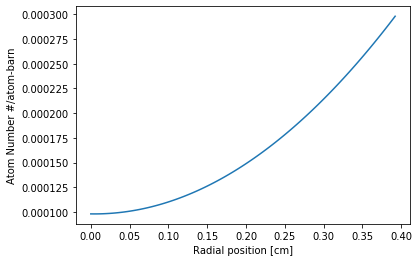

In [22]:
import numpy as np
z_n = np.array(a_n) 
zz = openmc.Zernike(z_n, fet_norm)
rr = np.linspace(0, fet_norm, 100)
plt.plot(rr, zz(rr, 0.0)) 
plt.xlabel('Radial position [cm]')
plt.ylabel('Atom Number #/atom-barn')

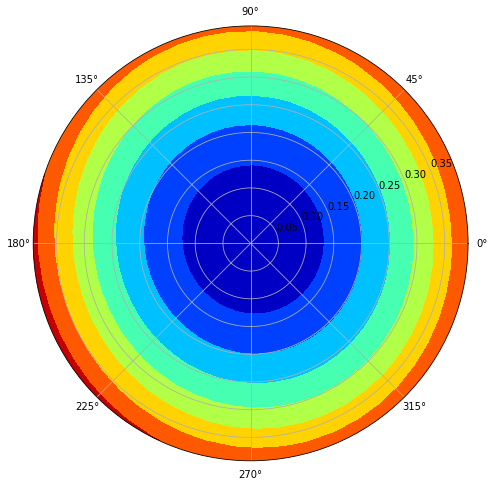

In [34]:
zz = openmc.Zernike(z_n, radius=fet_norm) 
#
# Using linspace so that the endpoint of 360 is included...
azimuths = np.radians(np.linspace(0, 360, 50))
zeniths = np.linspace(0, fet_norm, 100)
r, theta = np.meshgrid(zeniths, azimuths)
values = zz(zeniths, azimuths)
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(8,8))
ax.contourf(theta, r, values, cmap='jet')
#plt.show()

The following cases show how to reconstruct the flux distribution Zernike polynomials tallied results.

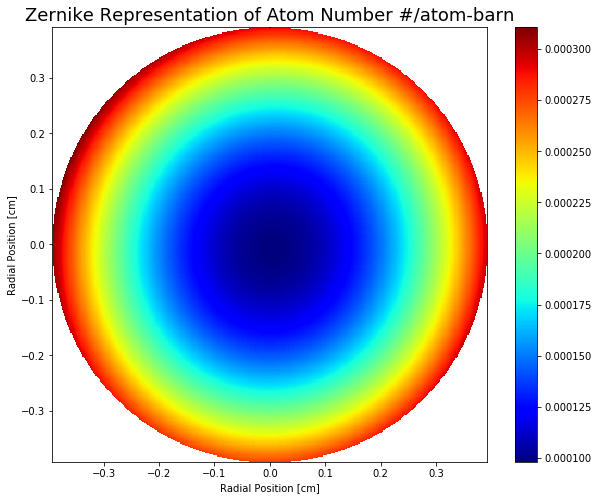

In [25]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)
#
zz = openmc.Zernike(z_n, radius=fet_norm) 
#
step = fet_norm/200
x = np.arange(-fet_norm, fet_norm, step)
[X,Y] = np.meshgrid(x,x);
[r, theta] = cart2pol(X,Y);
flux = np.zeros(X.shape);
flux.fill(np.nan)
zzmin = 1.0e300
zzmax = -1.0e300
for i in range(len(x)):
    for j in range(len(x)):
        if r[i][j]<=fet_norm:
            flux[i][j] = (zz(r[i][j], theta[i][j]))
            if flux[i][j]>zzmax:
                zzmax = flux[i][j]
            if flux[i][j]<zzmin:
                zzmin = flux[i][j]
#
#plt.pcolor(z2,theta, flux) 
plt.figure(figsize=(10,8))
plt.title('Zernike Representation of Atom Number #/atom-barn', fontsize=18)
plt.xlabel('Radial Position [cm]')
plt.ylabel('Radial Position [cm]')
plt.imshow(flux, cmap='jet', extent=[-fet_norm,fet_norm,-fet_norm,fet_norm])
plt.colorbar()

Let's plot the flux in radial direction with specific azimuthal angle ($\theta = 0.0$).